In [1]:
# !git clone 'https://github.com/Lorenz92/SKADC1.git'
# % cd SKADC1
# !echo $PWD

In [2]:
import pandas as pd
import numpy as np

import src.dataset as dataset
import src.config as config 
from src.utils import *
import src.models as models
import src.losses as loss

path = config.TRAIN_PATCHES_FOLDER
%load_ext autoreload
%autoreload 2

np.random.seed(config.RANDOM_SEED)

In [3]:
if 'google.colab' in str(get_ipython()):
  use_colab = True
  print('Running on CoLab')
else:
  use_colab = False
  print('Not running on CoLab')

Not running on CoLab


In [4]:
if use_colab:
    # Read file from Colab Notebook
    from google.colab import drive
    drive.mount('/content/drive')
    config.MODEL_WEIGHTS = "/content/drive/My Drive/Colab Notebooks/SKADC1"
    config.IMAGE_PATH = "/content/drive/My Drive/Colab Notebooks/SKADC1/asset/560Mhz_1000h.fits"

In [5]:
# Choose the feature extraction model
# backbone='baseline_36'
backbone='baseline_16'
# backbone='vgg16'

if backbone=='baseline_16':
    config.patch_dim = 50
    # config.patch_dim = 20
    config.resizePatch = True
    config.rpn_stride = 4
    config.num_rois = 8
    # config.anchor_box_scales = [16,32,64] # anchors in the original image size
    config.anchor_box_scales = [16, 24, 32, 64]
    # config.anchor_box_scales = [6, 8, 12, 16, 24, 32, 64]
    config.resizeFinalDim = 150
    # config.resizeFinalDim = 100
    input_shape_1 = config.resizeFinalDim
elif backbone=='baseline_36':
    config.patch_dim = 50
    config.resizePatch = True
    config.rpn_stride = 8
    config.num_rois = 8
    # config.anchor_box_scales = [16,32,64] # anchors in the original image size
    config.anchor_box_scales = [16, 32]
    # config.anchor_box_scales = [6, 8, 12, 16, 24, 32, 64]
    config.resizeFinalDim = 150
    input_shape_1 = config.resizeFinalDim
else:
    config.patch_dim = 100
    config.resizePatch = True
    config.rpn_stride = 16
    config.num_rois = 4
    config.resizeFinalDim = 600
    input_shape_1=config.resizeFinalDim
    config.anchor_box_scales = [32, 64, 128]


config.anchor_num = len(config.anchor_box_ratios)*len(config.anchor_box_scales)
input_shape_2=(None, 4)

print(config.resizePatch)
print(config.rpn_stride)

checkpoint = get_model_last_checkpoint(backbone)
print(f'Model last checkpoint: {checkpoint}')

True
4
Checking model checkpoints in directory /Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/model/baseline_16
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/model/baseline_16/1_frcnn_baseline_16.h5
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/model/baseline_16/23_frcnn_baseline_16.h5
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/model/baseline_16/0_frcnn_baseline_16.h5
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/model/baseline_16/5_frcnn_baseline_16.h5
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/model/baseline_16/19_frcnn_baseline_16.h5
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/model/baseline_16/93_frcnn_baseline_16.h5
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_proje

Dataset shape: (19222, 15)


,ID,RA (core),DEC (core),RA (centroid),DEC (centroid),FLUX,Core frac,BMAJ,BMIN,PA,SIZE,CLASS,SELECTION,x,y
0,24121695,-0.642227,-29.775242,-0.642316,-29.775211,0.000035,0.000000,5.600,5.551,328.554,1,1,1,19704.519,17712.942
1,20167150,-0.390473,-29.867493,-0.390667,-29.868851,0.029555,0.016924,107.110,43.263,191.258,1,1,1,18401.338,17160.919
2,20045120,-0.021411,-29.643486,-0.021359,-29.643561,0.000653,0.012185,5.037,3.525,276.587,1,1,1,16493.600,18506.577
3,33938384,-0.316375,-29.697647,-0.316375,-29.697647,0.000017,0.000000,0.847,0.266,346.641,2,1,1,18020.319,18182.095
4,7527248,-0.336528,-29.627335,-0.336527,-29.627338,0.000054,0.044763,3.343,1.515,279.006,1,1,1,18125.824,18600.680


Loading FITS file /Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/data/training/560Mhz_1000h.fits


100%|██████████| 19222/19222 [00:03<00:00, 5264.75it/s]


Initial dataset shape: (19222, 15)
Found 0 boxes with zero area
Rows to be deleted: 0
New dataset shape: (19222, 15)
Extending dataset with new computed columns...
Final cleaned dataset shape: (19222, 26)

Enlarging bboxes...
DONE - Enlarging bboxes...


,ID,RA (core),DEC (core),RA (centroid),DEC (centroid),FLUX,Core frac,BMAJ,BMIN,PA,...,x2,y2,major_semia_px,minor_semia_px,pa_in_rad,width,height,area_orig,area_cropped,class_label
0,24121695,-0.642227,-29.775242,-0.642316,-29.775211,0.000035,0.000000,5.600,5.551,328.554,...,19710.764566,17719.170105,6.264429,6.218255,5.734349,12.503792,12.461712,155.818657,155.818657,1_1
1,20167150,-0.390473,-29.867493,-0.390667,-29.868851,0.029555,0.016924,107.110,43.263,191.258,...,18509.603417,17209.564571,110.037236,44.503323,3.338082,216.538139,97.294352,21067.937901,21067.937901,1_1
2,20045120,-0.021411,-29.643486,-0.021359,-29.643561,0.000653,0.012185,5.037,3.525,276.587,...,16498.009965,18512.295208,5.738106,4.389739,4.827354,8.820318,11.444852,100.947234,100.947234,1_1
3,33938384,-0.316375,-29.697647,-0.316375,-29.697647,0.000017,0.000000,0.847,0.266,346.641,...,18023.322729,18184.661968,3.031418,2.541842,6.050027,6.014593,5.140670,30.919039,30.919039,2_1
4,7527248,-0.336528,-29.627335,-0.336527,-29.627338,0.000054,0.044763,3.343,1.515,279.006,...,18128.789688,18604.884928,4.236891,2.929772,4.869573,5.937378,8.419429,49.989332,49.989332,1_1



----------
Starting training image preprocessing...

Computing max and min pixel value in order to scale image to RGB range
Max pixel value = 0.0065856808796525
Removing negative noise...
Converting to RGB...
Removing positive noise and rescaling to 0-255 interval...

Mean and stdev of the half-gaussian that best fits with noise distribution:
mu=4.561610766868865e-14, stdev=4.5037468510513567e-07
End of training image preprocessing.


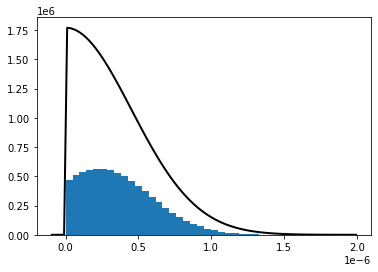

In [6]:
# Dataset parsing and loading
# use "subset" in config file to load a small portion of data for development/debugging purposes
ska_dataset = dataset.SKADataset(k=3, print_info=False, use_pb=False)

In [7]:
ska_dataset.cleaned_train_df[['width', 'height', 'area_orig', 'area_cropped']].describe()

,width,height,area_orig,area_cropped
count,19222.000000,19222.000000,19222.000000,19222.000000
mean,6.282190,6.285123,44.731314,44.731314
std,3.122242,2.910949,169.529219,169.529219
min,4.964839,4.964839,24.649628,24.649628
25%,5.114121,5.116855,26.770928,26.770928
50%,5.388071,5.394034,29.928541,29.928541
75%,6.193903,6.206960,39.145862,39.145862
max,216.538139,97.294352,21067.937901,21067.937901


In [8]:
ska_dataset.cleaned_train_df[['width', 'height', 'area_orig']].quantile([.1,.2,.3,.4,.5,.6,.7,.8,.9,.95,.98,.99,1.])

,width,height,area_orig
0.10,5.021579,5.022318,25.628098
0.20,5.079478,5.083666,26.354817
0.30,5.153434,5.154979,27.221580
0.40,5.250224,5.256348,28.358833
0.50,5.388071,5.394034,29.928541
0.60,5.596149,5.603978,32.164977
0.70,5.931373,5.932616,36.070023
0.80,6.568193,6.603042,43.494231
0.90,8.241342,8.188366,63.754795
0.95,10.577456,10.646052,100.988437


In [9]:
objects_to_ignore=[20167150, 27514971]


In [10]:
show_plot = False
# ska_dataset.generate_patches(limit=50, plot_patches=show_plot, objects_to_ignore=objects_to_ignore, source_dir=None, rgb_norm=True)
ska_dataset.generate_patches(limit=50, plot_patches=show_plot, objects_to_ignore=objects_to_ignore, source_dir='./data/training/patches', rgb_norm=True)
# ska_dataset.generate_patches(limit=1600, plot_patches=show_plot, objects_to_ignore=objects_to_ignore, source_dir='./data/training/patches', rgb_norm=True)

Attention: by using limit parameter you will retrieve only the first 50 patches

Retrieving patch 5_16501_16729_50

Retrieving patch 68_16501_16754_50

Retrieving patch 131_16501_16779_50

Retrieving patch 132_16526_16779_50

Retrieving patch 189_16376_16804_50

Retrieving patch 190_16401_16804_50

Retrieving patch 191_16426_16804_50

Retrieving patch 192_16451_16804_50

Retrieving patch 193_16476_16804_50

Retrieving patch 194_16501_16804_50

Retrieving patch 195_16526_16804_50

Retrieving patch 252_16376_16829_50

Retrieving patch 253_16401_16829_50

Retrieving patch 254_16426_16829_50

Retrieving patch 255_16451_16829_50

Retrieving patch 256_16476_16829_50

Retrieving patch 257_16501_16829_50

Retrieving patch 258_16526_16829_50

Retrieving patch 315_16376_16854_50

Retrieving patch 316_16401_16854_50

Retrieving patch 317_16426_16854_50

Retrieving patch 318_16451_16854_50

Retrieving patch 319_16476_16854_50

Retrieving patch 320_16501_16854_50

Retrieving patch 321_16526_16854_5

/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:483: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:483: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:483: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:483: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 378_16376_16879_50

Retrieving patch 379_16401_16879_50

Retrieving patch 380_16426_16879_50

Retrieving patch 381_16451_16879_50

Retrieving patch 382_16476_16879_50

Retrieving patch 383_16501_16879_50

Retrieving patch 384_16526_16879_50
Total number of generated patches: 32

Class list: ['2_3' '3_3']
Number of distinct class labels: 2


/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:483: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:483: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')


In [11]:
# ska_dataset.analyze_class_distribution()

In [12]:
# ska_dataset.split_train_val_stratified(random_state=42, val_portion=0.2)

# print(len(ska_dataset.train_patch_list))
# print(len(ska_dataset.val_patch_list))


minor class: ['384_16526_16879_50']
patch_to_be_repeated: []
32
Train list consists of 25 patches
Val list consists of 7 patches


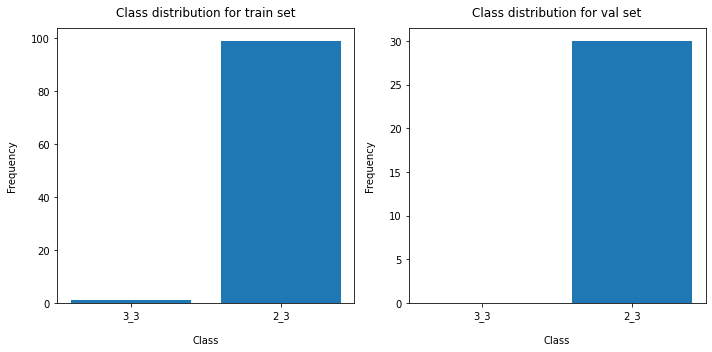

In [24]:
ska_dataset.split_train_val(random_state=42, val_portion=0.2, balanced=True)

## datagen + calc_rpn -> rpn_net -> rpn_to_roi -> calc_iou -> cls_net

# Training

In [15]:
# print_img(config.TRAIN_PATCHES_FOLDER, '3_16406_16729_20', show_data=True)


In [16]:
# # Debugging

# train_patch_list = ska_dataset.train_patch_list
# patches_folder_path=config.TRAIN_PATCHES_FOLDER

# train_datagen = prep.get_anchor_gt(patches_folder_path, ['20_16396_16729_20'], backbone, pixel_mean=None)
# image, [y_rpn_cls_true, y_rpn_reg_true], img_data_aug, _, _, patch_id = next(train_datagen)



### Get FRCNN model

In [36]:
rpn_model, detector_model, total_model = models.get_train_model(input_shape_1=input_shape_1, input_shape_2=input_shape_2, anchor_num=config.anchor_num, pooling_regions=config.pooling_regions, num_rois=config.num_rois, num_classes=len(ska_dataset.class_list)+1, backbone=backbone, use_expander=False)

rpn_model.summary()
detector_model.summary()
total_model.summary()

Model: "RegionProposal"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)    

### Load weights

In [18]:
ska_dataset.class_list

array(['2_3', '3_3'], dtype=object)

In [37]:
# checkpoint='0_frcnn_baseline_36.h5'
models.load_weigths(rpn_model, detector_model, backbone, resume_train=False, checkpoint=checkpoint)
# models.compile_models(rpn_model, detector_model, total_model, rpn_losses=[loss.rpn_loss_cls, loss.rpn_loss_regr], detector_losses=[loss.detector_loss_cls, loss.detector_loss_regr], class_list=ska_dataset.class_list)
models.compile_models(rpn_model, detector_model, total_model, rpn_losses=[loss.rpn_loss_cls, loss.rpn_loss_regr], detector_losses=[loss.categorical_focal_loss([0.25, 0.7, 0.05], 2.), loss.detector_loss_regr], class_list=ska_dataset.class_list)



In [ ]:
# Specifically checking backbone weights

# total_model.weights[24:25][0][0][0][0]

In [ ]:
# Check that all of the pretrained weights have been loaded.
import numpy as np
for i, j in zip(total_model.weights, rpn_model.weights): 
    # print(i,j)
    assert np.allclose(i,j), 'Weights don\'t match!'

### Train

- errore "Exception: 'a' cannot be empty unless no samples are taken" quando nel sampling ci sono meno di 4 roi
- errore "None type object is not iterable" dovuto al max(IoUs) quando calc_iou torna None, None, None, None
- patch di debug 1550_16376_16779_100
- capire il parametro classifier_regr_std in che modo influenza il training

- provare normalizzazione valori immagini di input
- provare a far passare più roi anzichè 4

In [ ]:
len(ska_dataset.train_patch_list)

In [ ]:
import tensorflow as tf

y_pred = np.ones((1,8,3))*4
a = np.ones((1,8,3))*.25
y_true=np.ones((1,8,3))
y_pred = y_pred / tf.reduce_sum(y_pred, -1, True)
cross_entropy = -y_true * K.log(y_pred)
print(y_pred)
print(cross_entropy)

In [ ]:
import keras.backend as K

# loss = [.25,.25,.25] * K.pow(1-y_pred[0,:,:], 2.) * cross_entropy
loss = cross_entropy
print(K.sum(loss, axis=-1))

In [ ]:
K.categorical_crossentropy(y_true, y_pred)

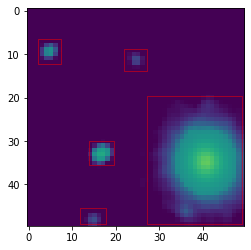

In [25]:
print_img(config.TRAIN_PATCHES_FOLDER, '384_16526_16879_50')


In [38]:
from src.train import *

val_patch_list = None
train_frcnn(rpn_model, detector_model, total_model, ['384_16526_16879_50'], val_patch_list, ska_dataset.class_list, num_epochs=100, patches_folder_path=config.TRAIN_PATCHES_FOLDER, backbone=backbone, resume_train=False)
# train_frcnn(rpn_model, detector_model, total_model, ska_dataset.train_patch_list, val_patch_list, ska_dataset.class_list, num_epochs=1, patches_folder_path=config.TRAIN_PATCHES_FOLDER, backbone=backbone, resume_train=True)

100%|██████████| 5/5 [00:00<00:00, 15152.83it/s]


Starting rpn model training on patch 384_16526_16879_50
Best IoU found in this run: 0.8556149709742915
Selected pos samples: 6
Selected neg samples: 2
Starting detector model training on batch
1/1 [==============================] - 9s 9s/step - rpn_cls: 1.0566 - rpn_regr: 0.3545 - detector_cls: 3.0221 - detector_regr: 20267.1230 - average number of objects: 6.0000
Mean number of bounding boxes from RPN overlapping ground truth boxes: 7.0
Classifier accuracy for bounding boxes from RPN: 0.25
Loss RPN classifier: 1.0565687417984009
Loss RPN regression: 0.35450369119644165
Loss Detector classifier: 3.022142171859741
Loss Detector regression: 20267.123046875
Total loss: 20271.556261479855, wrt best loss: 2.2505406700074673 
Elapsed time: 8.593444108963013


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 79/100
Average number of overlapping bounding boxes from RPN = 7.0 for 1 previous iterations
(150, 150)


100%|██████████| 5/5 [00:00<00:00, 7634.34it/s]


Starting rpn model training on patch 384_16526_16879_50
Best IoU found in this run: 0.8983957195230061
Selected pos samples: 6
Selected neg samples: 2
Starting detector model training on batch
1/1 [==============================] - 9s 9s/step - rpn_cls: 1.0742 - rpn_regr: 0.3273 - detector_cls: 3.0221 - detector_regr: 4638.4922 - average number of objects: 6.0000
Mean number of bounding boxes from RPN overlapping ground truth boxes: 10.0
Classifier accuracy for bounding boxes from RPN: 0.25
Loss RPN classifier: 1.0741835832595825
Loss RPN regression: 0.32728663086891174
Loss Detector classifier: 3.022142171859741
Loss Detector regression: 4638.4921875
Total loss: 4642.915799885988, wrt best loss: 2.2505406700074673 
Elapsed time: 9.02834701538086


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 80/100
Average number of overlapping bounding boxes from RPN = 10.0 for 1 previous iterations
(150, 150)


100%|██████████| 5/5 [00:00<00:00, 23831.27it/s]


Starting rpn model training on patch 384_16526_16879_50
Best IoU found in this run: 0.7797029683670719
Selected pos samples: 6
Selected neg samples: 2
Starting detector model training on batch
1/1 [==============================] - 8s 8s/step - rpn_cls: 1.2342 - rpn_regr: 0.3129 - detector_cls: 2.0498 - detector_regr: 1412.1765 - average number of objects: 6.0000
Mean number of bounding boxes from RPN overlapping ground truth boxes: 7.0
Classifier accuracy for bounding boxes from RPN: 0.375
Loss RPN classifier: 1.2342116832733154
Loss RPN regression: 0.31293410062789917
Loss Detector classifier: 2.049755573272705
Loss Detector regression: 1412.176513671875
Total loss: 1415.773415029049, wrt best loss: 2.2505406700074673 
Elapsed time: 8.348213911056519


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 81/100
Average number of overlapping bounding boxes from RPN = 7.0 for 1 previous iterations
(150, 150)


100%|██████████| 5/5 [00:00<00:00, 35424.86it/s]


Starting rpn model training on patch 384_16526_16879_50
Best IoU found in this run: 0.7797029683670719
Selected pos samples: 6
Selected neg samples: 2
Starting detector model training on batch
1/1 [==============================] - 8s 8s/step - rpn_cls: 1.1471 - rpn_regr: 0.4724 - detector_cls: 2.5191 - detector_regr: 404.0121 - average number of objects: 6.0000
Mean number of bounding boxes from RPN overlapping ground truth boxes: 9.0
Classifier accuracy for bounding boxes from RPN: 0.375
Loss RPN classifier: 1.1471377611160278
Loss RPN regression: 0.47240304946899414
Loss Detector classifier: 2.5191380977630615
Loss Detector regression: 404.0121154785156
Total loss: 408.1507943868637, wrt best loss: 2.2505406700074673 
Elapsed time: 7.928371906280518


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 82/100
Average number of overlapping bounding boxes from RPN = 9.0 for 1 previous iterations
(150, 150)


100%|██████████| 5/5 [00:00<00:00, 11580.08it/s]


Starting rpn model training on patch 384_16526_16879_50
Best IoU found in this run: 0.7499999531250029
Selected pos samples: 6
Selected neg samples: 2
Starting detector model training on batch
1/1 [==============================] - 8s 8s/step - rpn_cls: 0.9453 - rpn_regr: 0.4184 - detector_cls: 2.5185 - detector_regr: 437.7068 - average number of objects: 6.0000
Mean number of bounding boxes from RPN overlapping ground truth boxes: 10.0
Classifier accuracy for bounding boxes from RPN: 0.375
Loss RPN classifier: 0.9453357458114624
Loss RPN regression: 0.4184125065803528
Loss Detector classifier: 2.518451690673828
Loss Detector regression: 437.706787109375
Total loss: 441.58898705244064, wrt best loss: 2.2505406700074673 
Elapsed time: 8.0085129737854


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 83/100
Average number of overlapping bounding boxes from RPN = 10.0 for 1 previous iterations
(150, 150)


100%|██████████| 5/5 [00:00<00:00, 10039.02it/s]


Starting rpn model training on patch 384_16526_16879_50
Best IoU found in this run: 0.8615384593293886
Selected pos samples: 6
Selected neg samples: 2
Starting detector model training on batch
1/1 [==============================] - 8s 8s/step - rpn_cls: 1.1690 - rpn_regr: 0.2936 - detector_cls: 0.0267 - detector_regr: 0.5755 - average number of objects: 6.0000
Mean number of bounding boxes from RPN overlapping ground truth boxes: 7.0
Classifier accuracy for bounding boxes from RPN: 0.875
Loss RPN classifier: 1.1689693927764893
Loss RPN regression: 0.2935832440853119
Loss Detector classifier: 0.026718653738498688
Loss Detector regression: 0.5754724740982056
Total loss: 2.0647437646985054, wrt best loss: 2.2505406700074673 
Elapsed time: 7.830242156982422
Total loss decreased from 2.2505406700074673 to 2.0647437646985054, saving weights


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 84/100
Average number of overlapping bounding boxes from RPN = 7.0 for 1 previous iterations
(150, 150)


100%|██████████| 5/5 [00:00<00:00, 16181.73it/s]


Starting rpn model training on patch 384_16526_16879_50
Best IoU found in this run: 0.827586204858162
Selected pos samples: 3
Selected neg samples: 5
Starting detector model training on batch
1/1 [==============================] - 8s 8s/step - rpn_cls: 1.6242 - rpn_regr: 0.4461 - detector_cls: 0.0301 - detector_regr: 0.1846 - average number of objects: 3.0000
Mean number of bounding boxes from RPN overlapping ground truth boxes: 3.0
Classifier accuracy for bounding boxes from RPN: 0.625
Loss RPN classifier: 1.6241908073425293
Loss RPN regression: 0.44605785608291626
Loss Detector classifier: 0.030065137892961502
Loss Detector regression: 0.18455125391483307
Total loss: 2.28486505523324, wrt best loss: 2.0647437646985054 
Elapsed time: 8.177168846130371


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 85/100
Average number of overlapping bounding boxes from RPN = 3.0 for 1 previous iterations
(150, 150)


100%|██████████| 5/5 [00:00<00:00, 25637.56it/s]


Starting rpn model training on patch 384_16526_16879_50
Best IoU found in this run: 0.7499999531250029
Selected pos samples: 5
Selected neg samples: 3
Starting detector model training on batch
1/1 [==============================] - 8s 8s/step - rpn_cls: 1.2016 - rpn_regr: 0.3136 - detector_cls: 2.5185 - detector_regr: 384.4109 - average number of objects: 5.0000
Mean number of bounding boxes from RPN overlapping ground truth boxes: 5.0
Classifier accuracy for bounding boxes from RPN: 0.375
Loss RPN classifier: 1.201562762260437
Loss RPN regression: 0.31363505125045776
Loss Detector classifier: 2.518451690673828
Loss Detector regression: 384.41094970703125
Total loss: 388.444599211216, wrt best loss: 2.0647437646985054 
Elapsed time: 7.937881231307983


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 86/100
Average number of overlapping bounding boxes from RPN = 5.0 for 1 previous iterations
(150, 150)


100%|██████████| 5/5 [00:00<00:00, 36220.24it/s]


Starting rpn model training on patch 384_16526_16879_50
Best IoU found in this run: 0.7499999531250029
Selected pos samples: 3
Selected neg samples: 5
Starting detector model training on batch
1/1 [==============================] - 8s 8s/step - rpn_cls: 1.1405 - rpn_regr: 0.3263 - detector_cls: 1.5111 - detector_regr: 362.2349 - average number of objects: 3.0000
Mean number of bounding boxes from RPN overlapping ground truth boxes: 3.0
Classifier accuracy for bounding boxes from RPN: 0.625
Loss RPN classifier: 1.140524983406067
Loss RPN regression: 0.3262942433357239
Loss Detector classifier: 1.5110710859298706
Loss Detector regression: 362.23486328125
Total loss: 365.21275359392166, wrt best loss: 2.0647437646985054 
Elapsed time: 7.843352794647217


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 87/100
Average number of overlapping bounding boxes from RPN = 3.0 for 1 previous iterations
(150, 150)


100%|██████████| 5/5 [00:00<00:00, 37923.18it/s]


Starting rpn model training on patch 384_16526_16879_50
Best IoU found in this run: 0.7499999531250029
Selected pos samples: 4
Selected neg samples: 4
Starting detector model training on batch
1/1 [==============================] - 8s 8s/step - rpn_cls: 1.2219 - rpn_regr: 0.3531 - detector_cls: 1.5223 - detector_regr: 4215.3682 - average number of objects: 4.0000
Mean number of bounding boxes from RPN overlapping ground truth boxes: 4.0
Classifier accuracy for bounding boxes from RPN: 0.5
Loss RPN classifier: 1.2218928337097168
Loss RPN regression: 0.35310864448547363
Loss Detector classifier: 1.5222902297973633
Loss Detector regression: 4215.3681640625
Total loss: 4218.465455770493, wrt best loss: 2.0647437646985054 
Elapsed time: 7.870638847351074


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 88/100
Average number of overlapping bounding boxes from RPN = 4.0 for 1 previous iterations
(150, 150)


100%|██████████| 5/5 [00:00<00:00, 22944.77it/s]


Starting rpn model training on patch 384_16526_16879_50
Best IoU found in this run: 0.7533632270103964
Selected pos samples: 5
Selected neg samples: 3
Starting detector model training on batch
1/1 [==============================] - 8s 8s/step - rpn_cls: 1.4978 - rpn_regr: 0.4159 - detector_cls: 2.5185 - detector_regr: 9718.9453 - average number of objects: 5.0000
Mean number of bounding boxes from RPN overlapping ground truth boxes: 5.0
Classifier accuracy for bounding boxes from RPN: 0.375
Loss RPN classifier: 1.497771143913269
Loss RPN regression: 0.4158914089202881
Loss Detector classifier: 2.5184521675109863
Loss Detector regression: 9718.9453125
Total loss: 9723.377427220345, wrt best loss: 2.0647437646985054 
Elapsed time: 7.97210693359375


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 89/100
Average number of overlapping bounding boxes from RPN = 5.0 for 1 previous iterations
(150, 150)


100%|██████████| 5/5 [00:00<00:00, 46294.75it/s]


Starting rpn model training on patch 384_16526_16879_50
Best IoU found in this run: 0.7785888058915115
Selected pos samples: 6
Selected neg samples: 2
Starting detector model training on batch
1/1 [==============================] - 8s 8s/step - rpn_cls: 0.7769 - rpn_regr: 0.3508 - detector_cls: 1.0079 - detector_regr: 6613.5010 - average number of objects: 6.0000
Mean number of bounding boxes from RPN overlapping ground truth boxes: 8.0
Classifier accuracy for bounding boxes from RPN: 0.75
Loss RPN classifier: 0.7769330739974976
Loss RPN regression: 0.35082554817199707
Loss Detector classifier: 1.0078610181808472
Loss Detector regression: 6613.5009765625
Total loss: 6615.63659620285, wrt best loss: 2.0647437646985054 
Elapsed time: 7.9510509967803955


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 90/100
Average number of overlapping bounding boxes from RPN = 8.0 for 1 previous iterations
(150, 150)


100%|██████████| 5/5 [00:00<00:00, 11599.29it/s]


Starting rpn model training on patch 384_16526_16879_50
Best IoU found in this run: 0.7499999531250029
Selected pos samples: 6
Selected neg samples: 2
Starting detector model training on batch
1/1 [==============================] - 8s 8s/step - rpn_cls: 0.9556 - rpn_regr: 0.3261 - detector_cls: 3.0221 - detector_regr: 609.8839 - average number of objects: 6.0000
Mean number of bounding boxes from RPN overlapping ground truth boxes: 9.0
Classifier accuracy for bounding boxes from RPN: 0.25
Loss RPN classifier: 0.9555697441101074
Loss RPN regression: 0.32612451910972595
Loss Detector classifier: 3.022142171859741
Loss Detector regression: 609.8839111328125
Total loss: 614.1877475678921, wrt best loss: 2.0647437646985054 
Elapsed time: 7.98938775062561


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 91/100
Average number of overlapping bounding boxes from RPN = 9.0 for 1 previous iterations
(150, 150)


100%|██████████| 5/5 [00:00<00:00, 17246.32it/s]


Starting rpn model training on patch 384_16526_16879_50
Best IoU found in this run: 0.7499999531250029
Selected pos samples: 6
Selected neg samples: 2
Starting detector model training on batch
1/1 [==============================] - 8s 8s/step - rpn_cls: 1.3740 - rpn_regr: 0.3505 - detector_cls: 0.1410 - detector_regr: 0.4572 - average number of objects: 6.0000
Mean number of bounding boxes from RPN overlapping ground truth boxes: 8.0
Classifier accuracy for bounding boxes from RPN: 0.5
Loss RPN classifier: 1.3740441799163818
Loss RPN regression: 0.350468248128891
Loss Detector classifier: 0.1409570574760437
Loss Detector regression: 0.45715096592903137
Total loss: 2.322620451450348, wrt best loss: 2.0647437646985054 
Elapsed time: 7.872330904006958


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 92/100
Average number of overlapping bounding boxes from RPN = 8.0 for 1 previous iterations
(150, 150)


100%|██████████| 5/5 [00:00<00:00, 22721.04it/s]


Starting rpn model training on patch 384_16526_16879_50
Best IoU found in this run: 0.7499999531250029
Selected pos samples: 6
Selected neg samples: 2
Starting detector model training on batch
1/1 [==============================] - 8s 8s/step - rpn_cls: 1.1928 - rpn_regr: 0.3972 - detector_cls: 2.6083 - detector_regr: 283.4461 - average number of objects: 6.0000
Mean number of bounding boxes from RPN overlapping ground truth boxes: 7.0
Classifier accuracy for bounding boxes from RPN: 0.25
Loss RPN classifier: 1.1927924156188965
Loss RPN regression: 0.39724496006965637
Loss Detector classifier: 2.608304500579834
Loss Detector regression: 283.44610595703125
Total loss: 287.64444783329964, wrt best loss: 2.0647437646985054 
Elapsed time: 7.8341710567474365


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 93/100
Average number of overlapping bounding boxes from RPN = 7.0 for 1 previous iterations
(150, 150)


100%|██████████| 5/5 [00:00<00:00, 15022.58it/s]


Starting rpn model training on patch 384_16526_16879_50
Best IoU found in this run: 0.7499999531250029
Selected pos samples: 6
Selected neg samples: 2
Starting detector model training on batch
1/1 [==============================] - 9s 9s/step - rpn_cls: 1.3710 - rpn_regr: 0.3929 - detector_cls: 0.0321 - detector_regr: 0.3563 - average number of objects: 6.0000
Mean number of bounding boxes from RPN overlapping ground truth boxes: 7.0
Classifier accuracy for bounding boxes from RPN: 0.75
Loss RPN classifier: 1.371010422706604
Loss RPN regression: 0.39292290806770325
Loss Detector classifier: 0.03214740753173828
Loss Detector regression: 0.3563462495803833
Total loss: 2.152426987886429, wrt best loss: 2.0647437646985054 
Elapsed time: 8.937062978744507


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 94/100
Average number of overlapping bounding boxes from RPN = 7.0 for 1 previous iterations
(150, 150)


100%|██████████| 5/5 [00:00<00:00, 28886.39it/s]


Starting rpn model training on patch 384_16526_16879_50
Best IoU found in this run: 0.7499999531250029
Selected pos samples: 6
Selected neg samples: 2
Starting detector model training on batch
1/1 [==============================] - 9s 9s/step - rpn_cls: 1.0083 - rpn_regr: 0.3283 - detector_cls: 3.0221 - detector_regr: 1022.7810 - average number of objects: 6.0000
Mean number of bounding boxes from RPN overlapping ground truth boxes: 7.0
Classifier accuracy for bounding boxes from RPN: 0.25
Loss RPN classifier: 1.0082972049713135
Loss RPN regression: 0.32832297682762146
Loss Detector classifier: 3.022142171859741
Loss Detector regression: 1022.781005859375
Total loss: 1027.1397682130337, wrt best loss: 2.0647437646985054 
Elapsed time: 9.304800987243652


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 95/100
Average number of overlapping bounding boxes from RPN = 7.0 for 1 previous iterations
(150, 150)


100%|██████████| 5/5 [00:00<00:00, 12826.62it/s]


Starting rpn model training on patch 384_16526_16879_50
Best IoU found in this run: 0.9999999375000038
Selected pos samples: 6
Selected neg samples: 2
Starting detector model training on batch
1/1 [==============================] - 8s 8s/step - rpn_cls: 1.4319 - rpn_regr: 0.2305 - detector_cls: 0.0211 - detector_regr: 0.4775 - average number of objects: 6.0000
Mean number of bounding boxes from RPN overlapping ground truth boxes: 7.0
Classifier accuracy for bounding boxes from RPN: 0.875
Loss RPN classifier: 1.4318788051605225
Loss RPN regression: 0.23054121434688568
Loss Detector classifier: 0.021138988435268402
Loss Detector regression: 0.47754207253456116
Total loss: 2.1611010804772377, wrt best loss: 2.0647437646985054 
Elapsed time: 7.918328046798706


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 96/100
Average number of overlapping bounding boxes from RPN = 7.0 for 1 previous iterations
(150, 150)


100%|██████████| 5/5 [00:00<00:00, 34778.64it/s]


Starting rpn model training on patch 384_16526_16879_50
Best IoU found in this run: 0.9999999375000038
Selected pos samples: 6
Selected neg samples: 2
Starting detector model training on batch
1/1 [==============================] - 8s 8s/step - rpn_cls: 0.7445 - rpn_regr: 0.3229 - detector_cls: 0.0196 - detector_regr: 0.3317 - average number of objects: 6.0000
Mean number of bounding boxes from RPN overlapping ground truth boxes: 10.0
Classifier accuracy for bounding boxes from RPN: 0.75
Loss RPN classifier: 0.7444730401039124
Loss RPN regression: 0.322935551404953
Loss Detector classifier: 0.019552377983927727
Loss Detector regression: 0.331656813621521
Total loss: 1.418617783114314, wrt best loss: 2.0647437646985054 
Elapsed time: 7.876765251159668
Total loss decreased from 2.0647437646985054 to 1.418617783114314, saving weights


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 97/100
Average number of overlapping bounding boxes from RPN = 10.0 for 1 previous iterations
(150, 150)


100%|██████████| 5/5 [00:00<00:00, 33989.50it/s]


Starting rpn model training on patch 384_16526_16879_50
Best IoU found in this run: 0.9999999375000038
Selected pos samples: 6
Selected neg samples: 2
Starting detector model training on batch
1/1 [==============================] - 8s 8s/step - rpn_cls: 1.3817 - rpn_regr: 0.3746 - detector_cls: 2.0404 - detector_regr: 378.5789 - average number of objects: 6.0000
Mean number of bounding boxes from RPN overlapping ground truth boxes: 11.0
Classifier accuracy for bounding boxes from RPN: 0.375
Loss RPN classifier: 1.381657361984253
Loss RPN regression: 0.3746204376220703
Loss Detector classifier: 2.0403592586517334
Loss Detector regression: 378.5789489746094
Total loss: 382.37558603286743, wrt best loss: 1.418617783114314 
Elapsed time: 7.863943099975586


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 98/100
Average number of overlapping bounding boxes from RPN = 11.0 for 1 previous iterations
(150, 150)


100%|██████████| 5/5 [00:00<00:00, 28886.39it/s]


Starting rpn model training on patch 384_16526_16879_50
Best IoU found in this run: 0.9999999375000038
Selected pos samples: 6
Selected neg samples: 2
Starting detector model training on batch
1/1 [==============================] - 8s 8s/step - rpn_cls: 1.2436 - rpn_regr: 0.3526 - detector_cls: 2.0148 - detector_regr: 520.9332 - average number of objects: 6.0000
Mean number of bounding boxes from RPN overlapping ground truth boxes: 15.0
Classifier accuracy for bounding boxes from RPN: 0.5
Loss RPN classifier: 1.243598222732544
Loss RPN regression: 0.35261109471321106
Loss Detector classifier: 2.014761447906494
Loss Detector regression: 520.9331665039062
Total loss: 524.5441372692585, wrt best loss: 1.418617783114314 
Elapsed time: 7.92964506149292


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 99/100
Average number of overlapping bounding boxes from RPN = 15.0 for 1 previous iterations
(150, 150)


100%|██████████| 5/5 [00:00<00:00, 25795.23it/s]


Starting rpn model training on patch 384_16526_16879_50
Best IoU found in this run: 0.9999999375000038
Selected pos samples: 6
Selected neg samples: 2
Starting detector model training on batch
1/1 [==============================] - 8s 8s/step - rpn_cls: 1.0526 - rpn_regr: 0.3585 - detector_cls: 0.0643 - detector_regr: 0.4388 - average number of objects: 6.0000
Mean number of bounding boxes from RPN overlapping ground truth boxes: 14.0
Classifier accuracy for bounding boxes from RPN: 0.75
Loss RPN classifier: 1.0525538921356201
Loss RPN regression: 0.358486533164978
Loss Detector classifier: 0.06425084173679352
Loss Detector regression: 0.438754677772522
Total loss: 1.9140459448099136, wrt best loss: 1.418617783114314 
Elapsed time: 8.368375062942505


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 100/100
Average number of overlapping bounding boxes from RPN = 14.0 for 1 previous iterations
(150, 150)


100%|██████████| 5/5 [00:00<00:00, 34778.64it/s]


Starting rpn model training on patch 384_16526_16879_50
Best IoU found in this run: 0.9999999375000038
Selected pos samples: 6
Selected neg samples: 2
Starting detector model training on batch
1/1 [==============================] - 8s 8s/step - rpn_cls: 0.9011 - rpn_regr: 0.3948 - detector_cls: 2.0148 - detector_regr: 467.7079 - average number of objects: 6.0000
Mean number of bounding boxes from RPN overlapping ground truth boxes: 14.0
Classifier accuracy for bounding boxes from RPN: 0.5
Loss RPN classifier: 0.9010506868362427
Loss RPN regression: 0.39484259486198425
Loss Detector classifier: 2.014766216278076
Loss Detector regression: 467.70794677734375
Total loss: 471.01860627532005, wrt best loss: 1.418617783114314 
Elapsed time: 7.856674909591675
Training complete.


# Validation

In [41]:
rpn_model_eval, detector_model_eval, total_model_eval = models.get_eval_model(input_shape_1=input_shape_1, input_shape_2=input_shape_2, input_shape_fmap=None, anchor_num=config.anchor_num, pooling_regions=config.pooling_regions, num_rois=config.num_rois, num_classes=len(ska_dataset.class_list)+1, backbone=backbone, use_expander=False)

rpn_model_eval.summary()
detector_model_eval.summary()
total_model_eval.summary()

Model: "RegionProposal"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)    

In [42]:
# Models used for mAP eval
# cp = '36_frcnn_baseline_36.h5'
cp = '96_frcnn_baseline_16.h5'
models.load_weigths(rpn_model_eval, detector_model_eval, backbone, checkpoint=cp)
models.compile_models(rpn_model_eval, detector_model_eval, total_model_eval, rpn_losses=[loss.rpn_loss_cls, loss.rpn_loss_regr], detector_losses=[loss.detector_loss_cls, loss.detector_loss_regr], class_list=ska_dataset.class_list)

In [43]:
patch_id = ['384_16526_16879_50']
# patch_id = ska_dataset.train_patch_list
# print(patch_id)
# gt = pd.read_pickle(f'{config.TRAIN_PATCHES_FOLDER}/{patch_id[0]}/{patch_id[0]}.pkl')
# display(gt['class_label'])

preds, mAP, prec, recall = evaluate_model(rpn_model_eval, detector_model_eval, backbone, patch_id, ska_dataset.class_list, metric_threshold=.5)

(150, 150)
{0: '2_3', 1: '3_3', 2: 'bg'}
Predict
rpn_to_roi
[[[0. 0. 1.]
  [0. 0. 1.]
  [0. 0. 1.]
  [0. 0. 1.]
  [0. 0. 1.]
  [0. 0. 1.]
  [0. 0. 1.]
  [0. 0. 1.]]]
[[[-1.2700487e+03 -8.9697083e+01 -2.8187150e-01  9.0510300e+01
    0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00]
  [-1.2789146e+03 -9.1091255e+01  4.3464309e-01  9.1908264e+01
    0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00]
  [-9.4149976e+02 -7.6348656e+01 -7.1091905e+00  7.7055649e+01
    0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00]
  [-9.6248798e+02 -7.7084885e+01 -6.5693965e+00  7.7798843e+01
    0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00]
  [-1.0070550e+03 -7.9339020e+01 -6.0645823e+00  8.0066032e+01
    0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00]
  [-1.0398767e+03 -8.0645699e+01 -4.8906512e+00  8.1383469e+01
    0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00]
  [-1.0503502e+03 -8.3696671e+01 -7.3877015e+00  8.4437958e+01
    0.000

In [ ]:
preds

In [ ]:
print(config.patch_dim , float(config.resizeFinalDim))

In [ ]:
print_img(config.TRAIN_PATCHES_FOLDER, '5_16501_16729_50')

In [ ]:
anch = pd.read_pickle(f'{config.EVAL_RESULTS}/5_16501_16729_50/5_16501_16729_50.pkl')
display(anch)

In [ ]:
anch['width'] = anch['x2s'] - anch['x1s']
anch['heght'] = anch['y2s'] - anch['y1s']

In [ ]:
anch.describe() 

In [ ]:
print_img(config.TRAIN_PATCHES_FOLDER, '192_16451_16804_50', config.EVAL_RESULTS)

TODO - 20210508:
- [X] troncamento rumore a 1e-6 tramite half gaussian

TODO - 20210605:
- [X] modificare RPNNet in modo che dia in output anche la backbone - Lorenzo
- [X] scrivere bene training loop: salvare le loss in un df su disco + salvare pesi modello ad ogni giro (Lorenzo - finire di debuggare)

TODO - 20210620:
- [x] implementare mAP in una funzione che prende come parametro un modello o i suoi pesi
- [x] implementare resNet50
- [x] implementare predicted rois - Lorenzo
- [X] implementare plot loss training - Lorenzo
- [X] finire classe datasetv2 - Alice
- [X] check se su colab le performance sono migliori - Lorenzo

TODO - 20210627
- [X] split dataset su combinazioni classi - Alice
- [x] provare campionamento random patch ed osservare le due distribuzioni - Alice

TODO - 20210703
- [x] sistemare salvataggio loss training loop - Lorenzo
- [x] Riscalare immagini tra 0-255 - Alice
- [x] capire se passare tre immagini diverse come input
- [x] usare media vgg16 per zero-centering - Alice

TODO - 20210705
- [x] sistemare nomi funzioni dataset per trasformazione rgb

TODO - 20210711
- [x] rifattorizzare classe dataset spostando nel costruttore i metodi che calcolano i suoi attributi - Lorenzo
- [x] chek valori pixel in input per resnet
- [x] fare funzione per plottare le predictions
- [ ] trainare tutto su colab

TODO - 20210714
- [x] ragionare su come scalare le immagini fra 0 e 1, attualmente hanno tanti valori schiacciati a 0 e il massimo su tutto il train a a 0.4

TODO - 20210717
- [ ] Ablation study: provare a rimuovere stage4 nella resnet - se c'è tempo
- [x] Provare con nostra pixel_mean e con vgg16 pixel_mean -> per il momento abbiamo scartato la prima opzione
- [ ] Fare qualche analisi di distribuzione delle classi/dim box del dataset - Alice
- [x] Aggiungere normalizzazione dopo zero centering per resNet50, sulla base del range globale dell'immagine di training
- [ ] Provare pulizia dataset originale sulla base del rumore/flusso - Alice
- [ ] Cambiare nomi di tutto - alla fine
- [x] implementare zero-centering su volare medio RGB delle nostre patch
- [x] Funzione che trova l'ultimo checkpoint in colab prima del load_weights - Lorenzo

TODO - 20210801
- [x] Debuggare training baseline 8 e 16 - L
- [ ] Finire prove pulizia dataseet noise variando k - A

1.  Summary
    - riassunto progetto
2.  Background
    - SoTA + teoria di base
3.  System Description
    - descrizione dei nostri modelli e dei loro componenti (moduli)
4.  Experimental setup and results
    - dataset pre processing
    - training environment
    - metrics
    - results
5.  Results and error analysis
6.  Discussion

# Plotting

In [39]:
loss_history = np.load(f"./model/{backbone}/loss_history.npy")
print(loss_history.shape)

(100, 5)


In [ ]:
loss_history

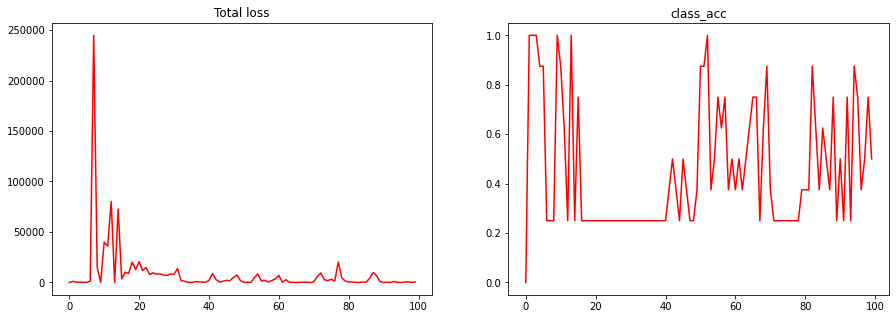

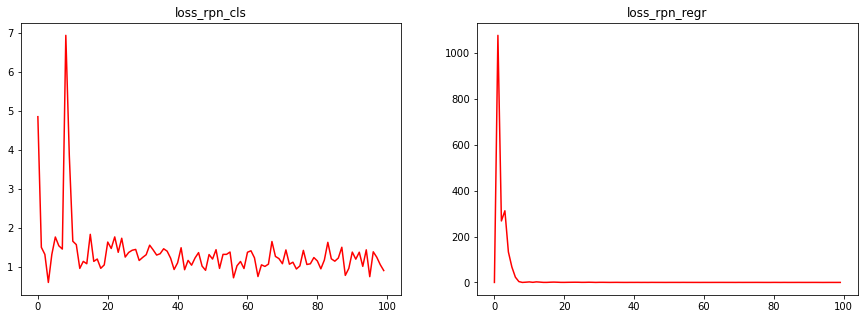

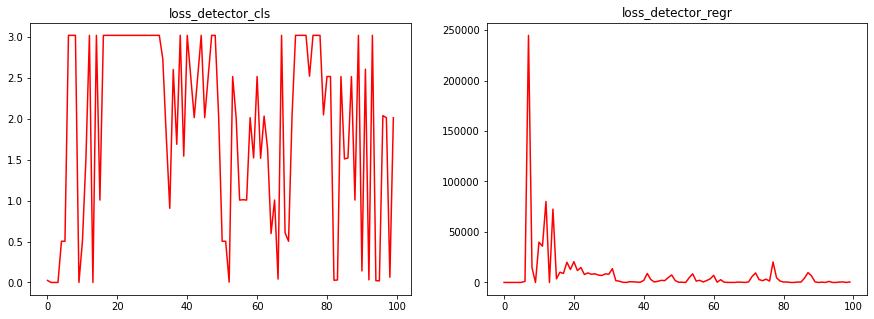

In [40]:
plot_loss(loss_history[:])

In [ ]:
loss_history[:,1].shape

In [ ]:
np.convolve(loss_history[1], np.ones(10), 'valid') / 10

In [ ]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

lsma_0 = moving_average(loss_history[100:,2], 200)


In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(np.arange(0, len(lsma_0)), lsma_0, 'r')
plt.title('rpn cls')

## Modelli da trainare:
epoch lenght = 200
- baseline_16: patch 50 -> 100, [8,16,32,64]-[1:1], 16roi, limit=4000, 10k epoche, focal_loss, norm: /255, no bilanciamento dataset, rgbNorm=True - A
- baseline_16: patch 50 -> 100, [8,16,32,64]-[1:1], 16roi, limit=4000, 10k epoche, NO focal_loss, norm: /255, no bilanciamento dataset, rgbNorm=True - A

- baseline_16: patch 20->100,  [8,16,32,64]-[1:1,1:2,2:1], 16roi, limit=4000, 10k epoche, focal_loss, norm: /255, no bilanciamento dataset, rgbNorm=True - L
- baseline_16: patch 20->100,  [8,16,32,64]-[1:1,1:2,2:1], 16roi, limit=4000, 10k epoche, focal_loss, norm: /255, no bilanciamento dataset, rgbNorm=True, layer 3 e 4 trainabili - L

- baseline_16: patch 100->100,  [8,16,32,64]-[1:1,1:2,2:1], 16roi, limit=4000, 10k epoche, focal_loss, norm: /255, no bilanciamento dataset, rgbNorm=True

- vgg16: 100 -> 600, [32,64,128,256,512]-[1:1,1:2,2:1], 16roi, limit=4000, 10k epoche, focal_loss, norm: /255, no bilanciamento dataset, rgbNorm=True